In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


total number of plots  78
loc =  1.0 scale =  0.14951789652356284
US
--


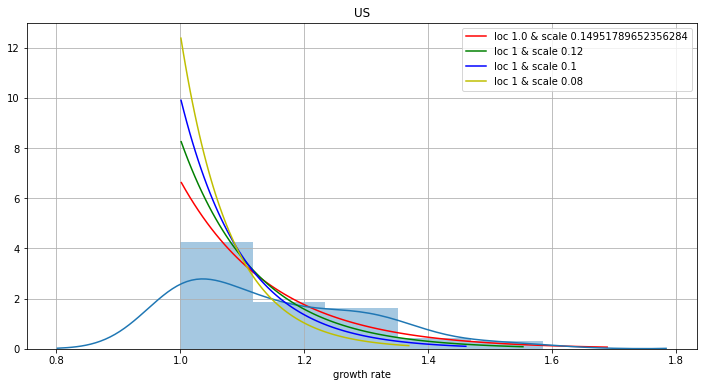

In [0]:
from scipy.stats import expon
x1 = 0
y1 = 0

total_growth_rate_values = []


file_path = "drive/My Drive/datafiles/US.csv"
df = pd.read_csv(file_path)
df = df.iloc[:,3:]
df['date'] = pd.to_datetime(df['date'])

growth_rate_values = df['growth_rate'].values

growth_rate_values = growth_rate_values[~np.isnan(growth_rate_values)]
growth_rate_values = growth_rate_values[growth_rate_values < 1.6]

loc_ex, scale_ex = sc.stats.expon.fit(growth_rate_values)

print("total number of plots ", len(growth_rate_values))
print("loc = ", loc_ex, "scale = ", scale_ex)
title = "US"
print(title)
plt.figure(figsize = (12,6))
plt.title(title)
plt.xlabel("growth rate")
plt.grid()

x_ex = np.linspace(expon.ppf(0.01,loc_ex,scale_ex),expon.ppf(0.99,loc_ex,scale_ex), 100)
plt.plot(x_ex, expon.pdf(x_ex,loc_ex,scale_ex),'r-', label='loc '+str(loc_ex)+" & scale "+str(scale_ex))

sns.distplot(growth_rate_values)

x_ex = np.linspace(expon.ppf(0.01,1,0.12),expon.ppf(0.99,1,0.12), 100)
plt.plot(x_ex, expon.pdf(x_ex,1,0.12),'g-', label='loc '+str(1)+" & scale "+str(0.12))

x_ex = np.linspace(expon.ppf(0.01,1,0.10),expon.ppf(0.99,1,0.10), 100)
plt.plot(x_ex, expon.pdf(x_ex,1,0.10),'b', label='loc '+str(1)+" & scale "+str(0.10))

x_ex = np.linspace(expon.ppf(0.01,1,0.08),expon.ppf(0.99,1,0.08), 100)
plt.plot(x_ex, expon.pdf(x_ex,1,0.08),'y', label='loc '+str(1)+" & scale "+str(0.08))

plt.legend()

total_growth_rate_values = np.append(total_growth_rate_values, growth_rate_values)
print("--")

In [0]:
# initial_confirmed_cases (N0)
# number_of_days (days)
# total_population (pop)
# infection probability factor (p1)
# Exposure factor (E1)
# threshold_growth_factor (tgf)


def modify_growth_func(prob_density, growth_factor, confirmed_cases, i_cases, pop, loc1, pE1):
  
  pop = pop - i_cases
  temp = growth_factor - loc1
  temp = (1-(confirmed_cases/pop))*pE1*temp
  growth_factor = loc1 + temp

  return growth_factor

 

def func_recover(confirmed_cases, days, coef_confirm = 9.24324666e-02, coef_days = -1.27972388e+02, intercept = 2594.9593455800195):
  temp = coef_confirm*confirmed_cases + coef_days*days + intercept
  if temp < 0 or temp > confirmed_cases:
    recover_cases = 0
  else:
    recover_cases = int(temp) 
  return recover_cases


 
def func_death(confirmed_cases, days, coef_confirm = 5.45522964e-02, coef_days = -7.00640594e+01, intercept = 1426.3529196804693):
  temp = coef_confirm*confirmed_cases + coef_days*days + intercept
  if temp < 0 or temp > confirmed_cases:
    death_cases = 0
  else:
    death_cases = int(temp) 
  return death_cases
	

def monte_carlo(N0, days, pop, pE1, tgf):
  loc1 = 1.00
  scale1 = 0.10

  pdfe = sc.stats.expon(scale = scale1, loc = loc1)   # probability density
  confirmed_cases_array = [N0]    # array to store confirmed cases

  initial_growth_factor_array = pdfe.rvs(size = days, random_state = 8)
  modified_growth_factor_array = [initial_growth_factor_array[0]]
  
  recover_cases_array = []
  death_cases_array = []
  i_cases_array = []

  #aux_growth_factors = pdfe.rvs(size = 2*days, random_state = 28)
  #aux_growth_factors = aux_growth_factors[aux_growth_factors < tgf]

  for i in range(1, days):

    # initilisation
    growth_factor = initial_growth_factor_array[i-1]
    recover_cases_array.append(func_recover(confirmed_cases_array[-1], i))
    death_cases_array.append(func_death(confirmed_cases_array[-1], i))

    #if growth_factor > tgf:
      #growth_factor = 1.01

    i_cases_array.append(recover_cases_array[-1] + death_cases_array[-1])

    growth_factor = modify_growth_func(pdfe, growth_factor, confirmed_cases_array[-1], i_cases_array[-1], pop, loc1, pE1)
    modified_growth_factor_array.append(growth_factor)
    confirmed_cases_array.append(confirmed_cases_array[i-1]*modified_growth_factor_array[i-1])
  
  recover_cases_array.append(func_recover(confirmed_cases_array[-1], i))
  death_cases_array.append(func_death(confirmed_cases_array[-1], i))

  return modified_growth_factor_array, confirmed_cases_array, recover_cases_array, death_cases_array

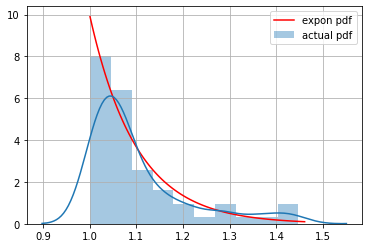

In [0]:
growth_factor_array, confirmed_cases, recover_cases, death_cases = monte_carlo(350,70,328200000, pE1 = 1, tgf=1.3)

loc1 = 1.00
scale1 = 0.10

from scipy.stats import expon 

# plot the probability distribution function which is used to generate growth factors
plt.grid()
x = np.linspace(expon.ppf(0.01,loc1,scale1),expon.ppf(0.99,loc1,scale1), 100)
plt.plot(x, expon.pdf(x,loc1,scale1),'r-', label='expon pdf')

# plot the probability density of the growth factors randomly generated from above pdf
sns.distplot(growth_factor_array, label = "actual pdf")
plt.legend()

total number of confirmed cases on day 70 208412.81906469676
total number of recover cases on day 70 13028
total number of death cases on day 70 7961


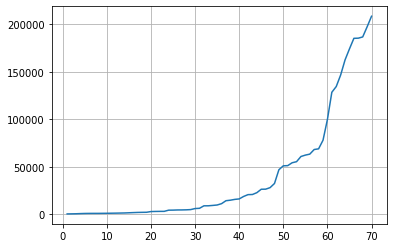

In [0]:
x = [i+1 for i in range(70)]
plt.grid()
plt.plot(x, confirmed_cases)
print("total number of confirmed cases on day "+str(x[-1])+" "+str(confirmed_cases[-1]))
print("total number of recover cases on day "+str(x[-1])+" "+str(recover_cases[-1]))
print("total number of death cases on day "+str(x[-1])+" "+str(death_cases[-1]))

In [0]:
df = pd.read_csv("US.csv")
confirmed_actual_values = df['Confirmed'].values
print(len(confirmed_actual_values))

recover_actual_values = df['Recovered'].values
print(len(recover_actual_values))
death_actual_values = df['Deaths'].values


93
93


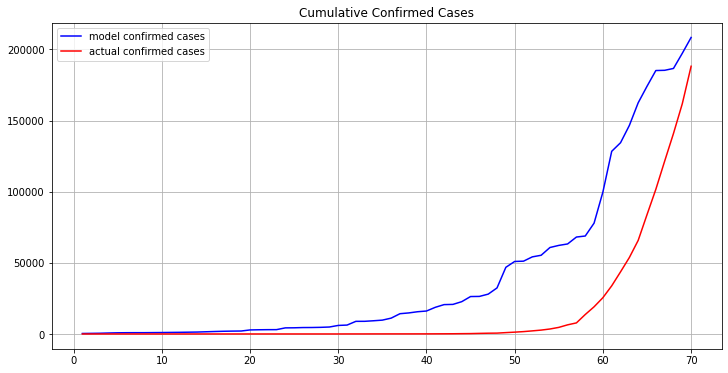

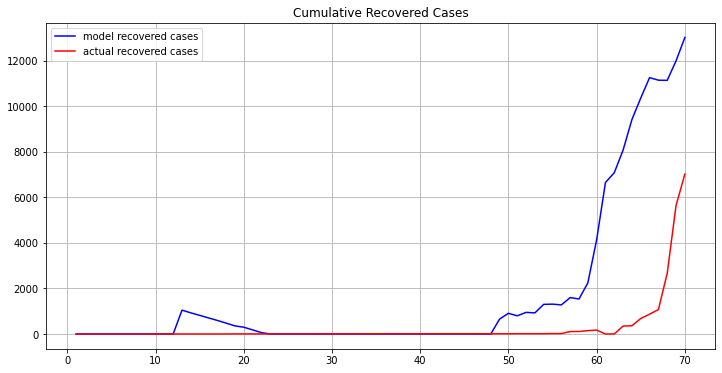

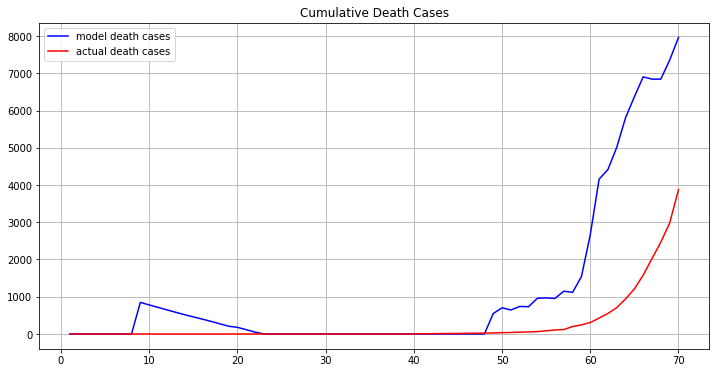

In [0]:
days = [i+1 for i in range(70)]

confirmed_actual_values2 = confirmed_actual_values[:70]
confirmed_cases2 = confirmed_cases
assert len(confirmed_actual_values2) == len(confirmed_cases2)
plt.figure(figsize = (12,6))
plt.title("Cumulative Confirmed Cases")
plt.grid()
plt.plot(days, confirmed_cases2, label = 'model confirmed cases', color = 'b')
plt.plot(days, confirmed_actual_values2, label = 'actual confirmed cases', color = 'r')
plt.legend()

recover_actual_values2 = recover_actual_values[:70]
recover_cases2 = recover_cases
assert len(recover_actual_values2) == len(recover_cases2)
plt.figure(figsize = (12,6))
plt.title("Cumulative Recovered Cases")
plt.grid()
plt.plot(days, recover_cases2, label = 'model recovered cases', color = 'b')
plt.plot(days, recover_actual_values2, label = 'actual recovered cases', color = 'r')
plt.legend()


death_actual_values2 = death_actual_values[:70]
death_cases2 = death_cases
plt.figure(figsize = (12,6))
plt.title("Cumulative Death Cases")
plt.grid()
plt.plot(days, death_cases2, label = 'model death cases', color = 'b')
plt.plot(days, death_actual_values2, label = 'actual death cases', color = 'r')
plt.legend()

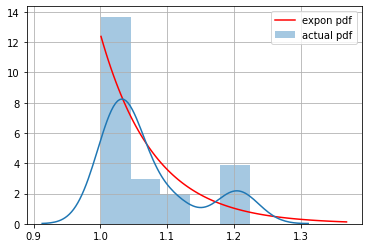

In [0]:
l_growth_factor_array, l_confirmed_cases, l_recover_cases, l_death_cases = monte_carlo(confirmed_cases[-1],23,328200000, pE1 = 0.55, tgf=1.4)

loc1 = 1.00
scale1 = 0.08

from scipy.stats import expon 

# plot the probability distribution function which is used to generate growth factors
plt.grid()
x = np.linspace(expon.ppf(0.01,loc1,scale1),expon.ppf(0.99,loc1,scale1), 100)
plt.plot(x, expon.pdf(x,loc1,scale1),'r-', label='expon pdf')

# plot the probability density of the growth factors randomly generated from above pdf
sns.distplot(l_growth_factor_array, label = "actual pdf")
plt.legend()

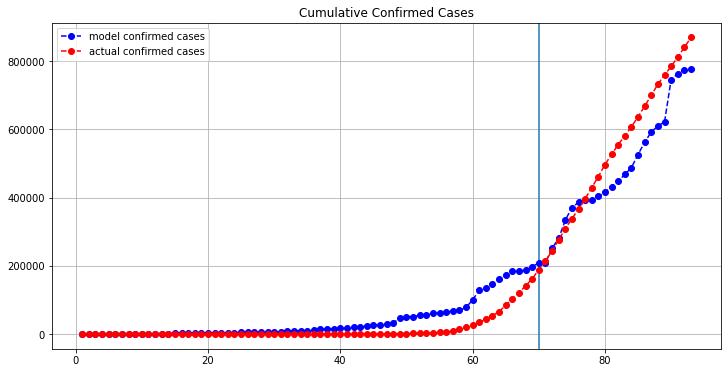

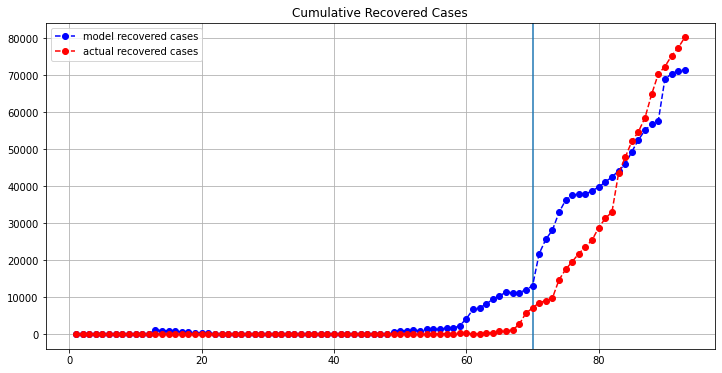

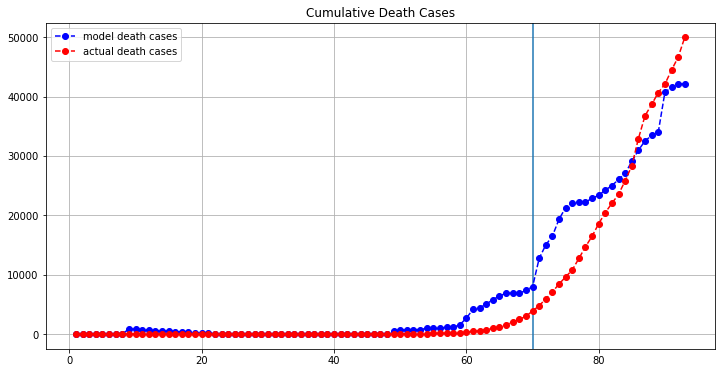

In [0]:
days = [i+1 for i in range(93)]



confirmed_cases = confirmed_cases + l_confirmed_cases
plt.figure(figsize = (12,6))
plt.axvline(x=70)
plt.title("Cumulative Confirmed Cases")
plt.grid()
plt.plot(days, confirmed_cases, label = 'model confirmed cases', color = 'b', marker = "o", linestyle = "--")
plt.plot(days, confirmed_actual_values, label = 'actual confirmed cases', color = 'r', marker = "o", linestyle = "--")
plt.legend()


recover_cases = recover_cases + l_recover_cases
plt.figure(figsize = (12,6))
plt.axvline(x=70)
plt.title("Cumulative Recovered Cases")
plt.grid()
plt.plot(days, recover_cases, label = 'model recovered cases', color = 'b', marker = "o", linestyle = "--")
plt.plot(days, recover_actual_values, label = 'actual recovered cases', marker = "o",color = 'r', linestyle = "--")
plt.legend()


death_cases = death_cases + l_death_cases
plt.figure(figsize = (12,6))
plt.axvline(x=70)
plt.title("Cumulative Death Cases")
plt.grid()
plt.plot(days, death_cases, label = 'model death cases', color = 'b', marker = "o", linestyle = "--")
plt.plot(days, death_actual_values, label = 'actual death cases', color = 'r', marker = "o", linestyle = '--')
plt.legend()

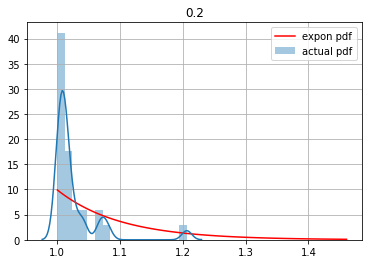

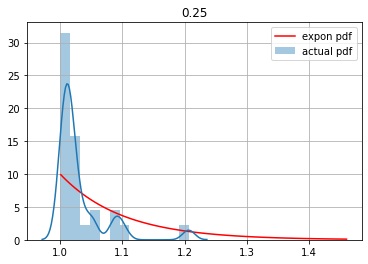

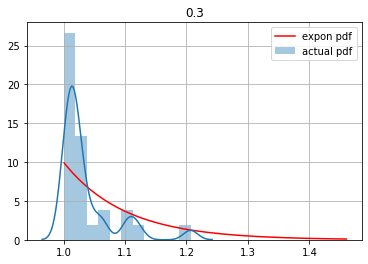

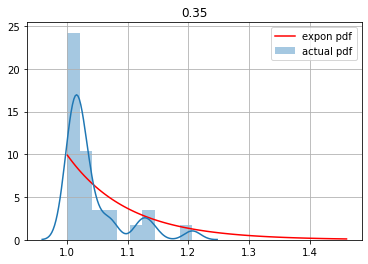

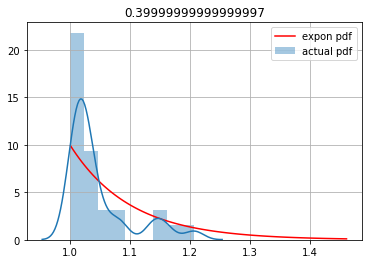

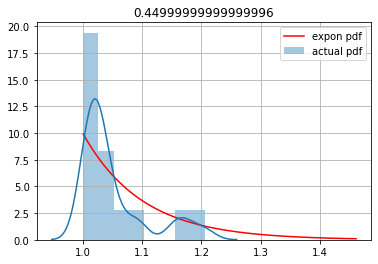

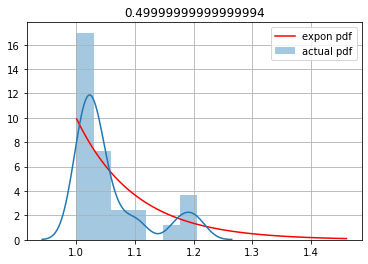

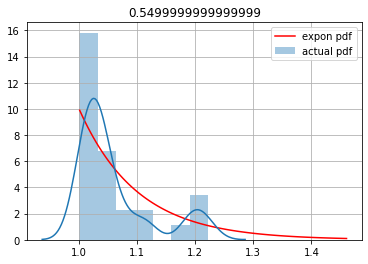

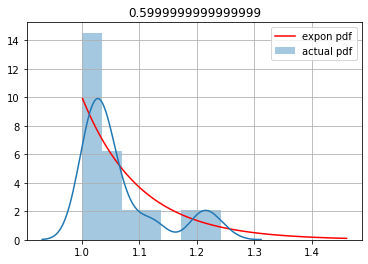

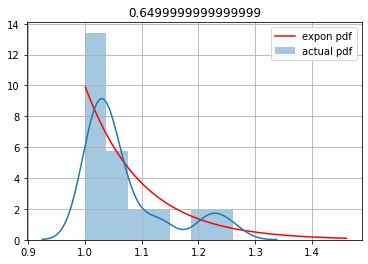

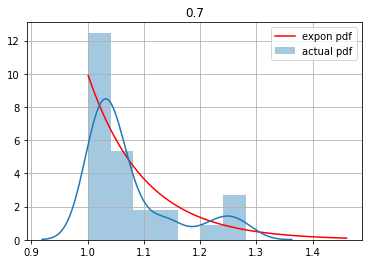

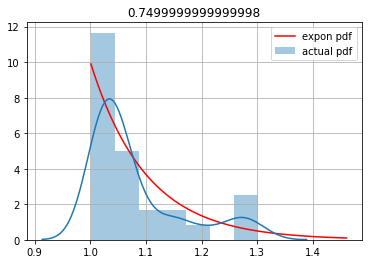

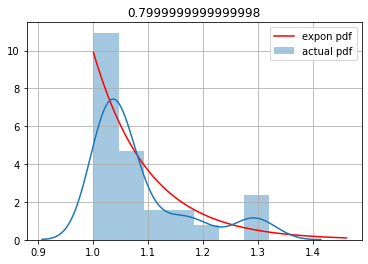

In [0]:
import numpy as np
from scipy.stats import expon 
pe_val = [i for i in np.arange(0.2, 0.8, 0.05)]


growth_factor_array_array = []
confirmed_cases_array = []
recover_cases_array = []
death_cases_array = []

for pe in pe_val:
  l2_growth_factor_array, l2_confirmed_cases, l2_recover_cases, l2_death_cases = monte_carlo(confirmed_cases[-1],28,328200000, pE1 = pe, tgf=1.4)
  loc1 = 1.00
  scale1 = 0.10

  # plot the probability distribution function which is used to generate growth factors
  plt.figure()
  plt.title(str(pe))
  plt.grid()
  x = np.linspace(expon.ppf(0.01,loc1,scale1),expon.ppf(0.99,loc1,scale1), 100)
  plt.plot(x, expon.pdf(x,loc1,scale1),'r-', label='expon pdf')

  # plot the probability density of the growth factors randomly generated from above pdf
  sns.distplot(l2_growth_factor_array, label = "actual pdf")
  plt.legend()

  growth_factor_array_array.append(l2_growth_factor_array)
  confirmed_cases_array.append(l2_confirmed_cases)
  recover_cases_array.append(l2_recover_cases)
  death_cases_array.append(l2_death_cases)

1568642.5740774232
1778621.0214656855
2014024.4705711005
2277616.781906561
2572426.3514010585
2901767.1290399274
3269260.7092590067
3678859.441850158
4134870.485318871
4641980.692194408
5205282.17718743
5830298.373289698
6523010.3288025


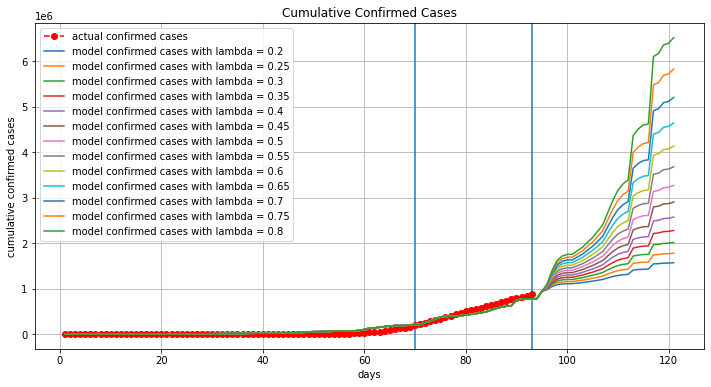

In [0]:
days = [i+1 for i in range(93)]
days1 = [i+1 for i in range(121)]
plt.figure(figsize = (12,6))
plt.axvline(x=70)
plt.axvline(x=93)
plt.title("Cumulative Confirmed Cases")
plt.grid()



plt.plot(days, confirmed_actual_values, label = 'actual confirmed cases', color = 'r', marker = "o", linestyle = "--")

for i in range(len(confirmed_cases_array)):
  confirmed_cases2 = confirmed_cases + confirmed_cases_array[i]
  print(confirmed_cases2[-1])
  plt.xlabel("days")
  plt.ylabel("cumulative confirmed cases")
  plt.plot(days1, confirmed_cases2,  label = 'model confirmed cases with lambda = '+str(round(pe_val[i],2)))
 
plt.legend()


1339402.5740774232
1518517.0214656855
1719320.4705711005
1944168.781906561
2195645.3514010585
2476578.1290399274
2790055.7092590067
3139450.441850158
3528434.485318871
3961006.692194408
4441512.17718743
4974660.373289698
5565554.3288025


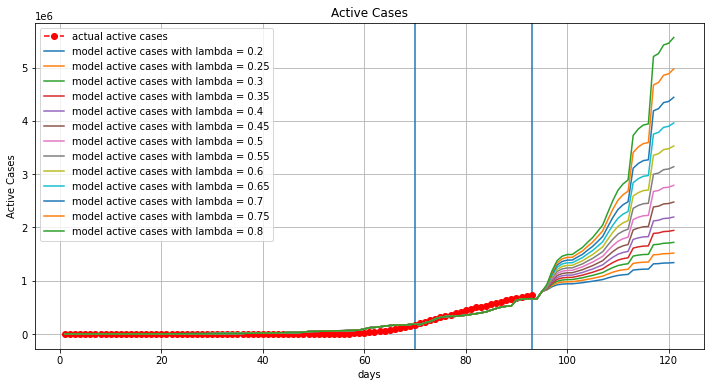

In [0]:
days = [i+1 for i in range(93)]
days1 = [i+1 for i in range(121)]
plt.figure(figsize = (12,6))
plt.axvline(x=70)
plt.axvline(x=93)
plt.title("Active Cases")
plt.grid()


np_confirmed_actual_values = np.asarray(confirmed_actual_values)
np_recover_actual_values = np.asarray(recover_actual_values)
np_death_actual_values = np.asarray(death_actual_values)

np_actual_active_values = np_confirmed_actual_values - np_recover_actual_values - np_death_actual_values
plt.plot(days, np_actual_active_values, label = 'actual active cases', color = 'r', marker = "o", linestyle = "--")


for i in range(len(confirmed_cases_array)):
  confirmed_cases2 = confirmed_cases + confirmed_cases_array[i]
  np_confirmed_cases2 = np.asarray(confirmed_cases2)

  recover_cases2 = recover_cases + recover_cases_array[i]
  np_recover_cases2 = np.asarray(recover_cases2)

  death_cases2 = death_cases + death_cases_array[i]
  np_death_cases2 = np.asarray(death_cases2)

  np_active_cases = np_confirmed_cases2 - np_recover_cases2 - np_death_cases2

  print(np_active_cases[-1])
  plt.xlabel("days")
  plt.ylabel("Active Cases")
  plt.plot(days1, np_active_cases,  label = 'model active cases with lambda = '+str(round(pe_val[i],2)))
 
plt.legend()

85107
96562
109404
123783
139866
157832
177880
200224
225101
252765
283494
317590
355379


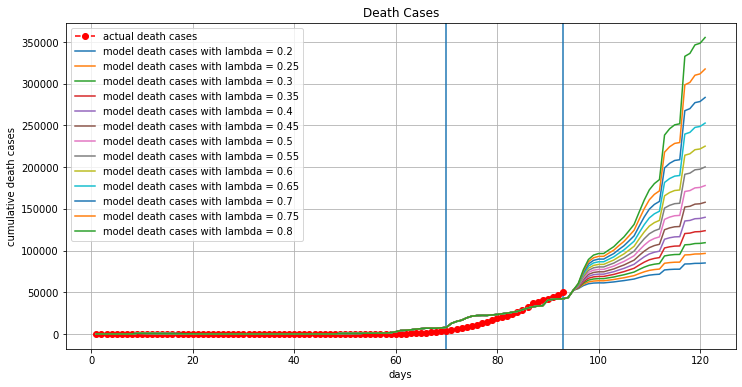

In [0]:
days = [i+1 for i in range(93)]
days1 = [i+1 for i in range(121)]
plt.figure(figsize = (12,6))
plt.axvline(x=70)
plt.axvline(x=93)
plt.title("Death Cases")
plt.grid()


np_death_actual_values = np.asarray(death_actual_values)
plt.plot(days, np_death_actual_values, label = 'actual death cases', color = 'r', marker = "o", linestyle = "--")


for i in range(len(confirmed_cases_array)):
  
  death_cases2 = death_cases + death_cases_array[i]
  np_death_cases2 = np.asarray(death_cases2)

  print(np_death_cases2[-1])
  plt.xlabel("days")
  plt.ylabel("cumulative death cases")
  plt.plot(days1, np_death_cases2,  label = 'model death cases with lambda = '+str(round(pe_val[i],2)))
 
plt.legend()

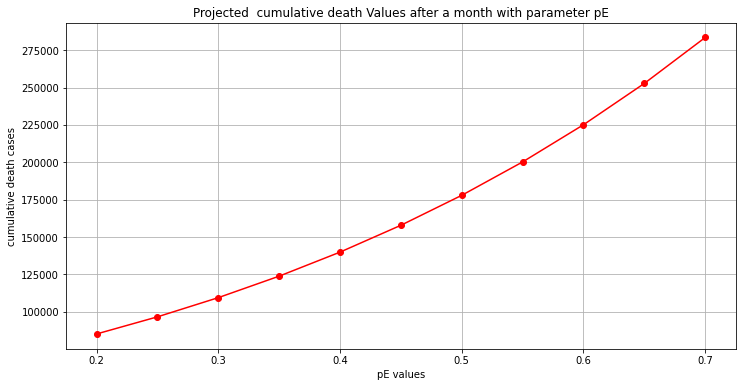

In [0]:
pe = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
deaths = [85107, 96562, 109404, 123783, 139866, 157832, 177880, 200224, 225101, 252765, 283494]
confirmed_values = [1568642, 1778621, 2014024, 2277616, 2572426, 2901767, 3269260, 3678859, 4134870, 4641980, 5205282]
plt.figure(figsize = (12,6))
plt.title("Projected  cumulative death Values after a month with parameter pE")
plt.ylabel("cumulative death cases")
plt.xlabel("pE values")
plt.grid()
plt.plot(pe, deaths, marker = "o", color = 'r')

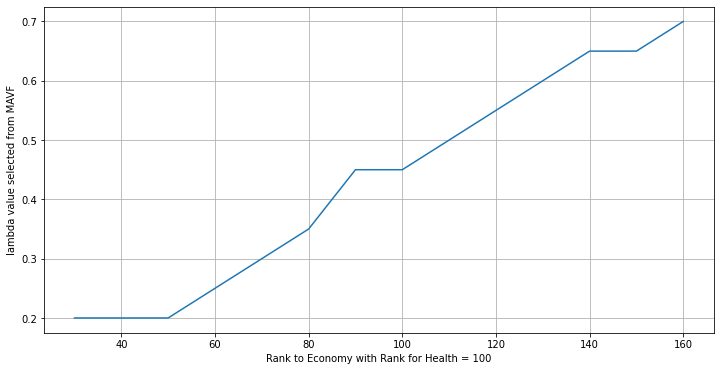

In [0]:
import matplotlib.pyplot as plt
x = [i for i in range(30, 170, 10)]
y = [0.2, 0.2, 0.2, 0.25, 0.3, 0.35, 0.45, 0.45, 0.5, 0.55, 0.6, 0.65, 0.65, 0.7]

plt.figure(figsize = (12,6))
plt.grid()
plt.xlabel("Rank to Economy with Rank for Health = 100")
plt.ylabel("lambda value selected from MAVF")
plt.plot(x,y)
